# Calculate Text-Similarity By IF-IDF
In this step, we calculate the monthly similarities of summaries of cs paper from 2014 to 2020. The main idea is that after we use if-idf model to transdform the texts into vectors, the similarity of certain month is calculated by averrageing the cosine similaritis between every text-vector of the current month and every text-vector of all months before the current one.   

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
import os
path="/content/drive/My Drive/Research/Data/"

os.chdir(path)
os.listdir(path)

Mounted at /content/drive/


['english.txt',
 '2019_2020_all_data_final.csv',
 '2014_abs',
 '2015_abs',
 '2016_abs',
 '2017_abs',
 '2018_abs',
 'My_Process',
 'all_data_statistic.csv',
 'top_category_details.csv',
 'top5_statistic_months.csv',
 'top5_statistics_col_1.csv',
 'cs_summary',
 'My_result']

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import gc
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from time import sleep

In [ ]:
import nltk
nltk.download("stopwords")
#导入停用词
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
'''
#导入停用词
stopwords_source=pd.read_table(path+'english.txt',header=None)
stopwords=[]
for word in stopwords_source[0]:
  word=str(word)
  if len(word)>2:
      element=re.split('\W+',word)
      for ele in element:
        ele=str(ele)
        if ele not in stopwords:
          stopwords.append(ele)
'''

"\n#导入停用词\nstopwords_source=pd.read_table(path+'english.txt',header=None)\nstopwords=[]\nfor word in stopwords_source[0]:\n  word=str(word)\n  if len(word)>2:\n      element=re.split('\\W+',word)\n      for ele in element:\n        ele=str(ele)\n        if ele not in stopwords:\n          stopwords.append(ele)\n"

In [ ]:
#加载index_year  （包含data里的数据划分节点数）
index_year_ = np.load(path+'My_Process/index_year.npy')
index_year_=index_year_.tolist()
index_year_

[0,
 1049,
 1855,
 2648,
 3643,
 4641,
 5490,
 6377,
 7215,
 8138,
 9015,
 9896,
 10802,
 11688,
 12600,
 13623,
 14707,
 15801,
 16839,
 17925,
 18823,
 19919,
 20939,
 22006,
 23048,
 24147,
 25264,
 26513,
 27940,
 29355,
 30790,
 32106,
 33408,
 34860,
 36232,
 37743,
 39037,
 40355,
 41803,
 43605,
 45296,
 47215,
 48892,
 50829,
 52732,
 54653,
 56226,
 58162,
 59822,
 61505,
 63374,
 65553,
 67695,
 70278,
 72562,
 74915,
 77055,
 79263,
 81590,
 83993,
 85957,
 88205,
 90558,
 93294,
 96563,
 99547,
 102381,
 105281,
 108241,
 111373,
 114337,
 117190,
 119700,
 122295,
 125227,
 129153,
 134877,
 139188,
 142121,
 146427,
 150244,
 154325,
 160190,
 165023,
 165165]

In [ ]:
# 加载处理好的data

'''
fileopen = open(path+'My_Process/clean_cs_summary_onlyN.txt','r')
data = fileopen.readlines()
fileopen.close()
'''
# 读文件里面的数据转化为二维列表
def read_list(file_path):
    file1 = open(file_path, "r")
    list_row =file1.readlines()
    list_source = []
    for i in range(len(list_row)):
        column_list = list_row[i].strip().split("\t")  # 每一行split后是一个列表
        list_source.append(column_list)                # 在末尾追加到list_source
    for i in range(len(list_source)):  # 行数
        for j in range(len(list_source[i])):  # 列数
            list_source[i][j]=list_source[i][j]
    file1.close()
    return list_source


# 加载词表
scource = read_list(path+'My_Process/clean_cs_title.txt')



In [ ]:
scource[:10]

[['radial basis function process neural network training base generalize distance strategy'],
 ['efficient reliable hybrid cloud architechture big datum'],
 ['internet thing concept building block application challenge'],
 ['analysis diversion driver'],
 ['business model context web paradigm'],
 ['performance impact lock free algorithm multicore communication api'],
 ['reduce computational cost multi objective evolutionary algorithm filter worthless individual'],
 ['clean transformation standard print form use neural model'],
 ['application modify fractal signature method terrain classification synthetic aperture radar image'],
 ['statistical analysis base hypothesis testing method biological knowledge discovery']]

In [ ]:
data=[]
for doc in scource:
  article =''
  for word in doc:
    article = article + ' ' + word
  data.append(article)

In [ ]:
data[:10]

[' radial basis function process neural network training base generalize distance strategy',
 ' efficient reliable hybrid cloud architechture big datum',
 ' internet thing concept building block application challenge',
 ' analysis diversion driver',
 ' business model context web paradigm',
 ' performance impact lock free algorithm multicore communication api',
 ' reduce computational cost multi objective evolutionary algorithm filter worthless individual',
 ' clean transformation standard print form use neural model',
 ' application modify fractal signature method terrain classification synthetic aperture radar image',
 ' statistical analysis base hypothesis testing method biological knowledge discovery']

In [ ]:
def similarity_processor(process_number,begin_months,last_months,interaction):
 # 计算三个重要节点
 process_number = process_number
 begin_months = begin_months
 last_months = last_months
 interaction = interaction

 start_index =index_year_[len(index_year_)-process_number-last_months-begin_months-interaction]
 end_of_begin = index_year_[len(index_year_)-process_number-last_months-interaction]-1
 start_of_last = index_year_[len(index_year_)-process_number-last_months]
 end_index = index_year_[len(index_year_)-process_number]-1
 #print(start_index,end_of_begin,start_of_last,end_index)

 #抽出子数据并重组序数index
 sub_data = data[start_index:end_index]

 start_of_last = start_of_last - start_index
 end_of_begin = end_of_begin - start_index
 end_index = end_index - start_index-(start_of_last - end_of_begin) 
 start_index = 0
 print('all data complete')

 # 用if-idf算法
 transfer = TfidfVectorizer(stop_words=stopwords)
 #transfer = CountVectorizer(stop_words=stopwords)

 tfidf_result = transfer.fit_transform(sub_data)
 print('complet if algorithm')
 #print('data_new:\n',result.toarray())
 #print('特征名字：\n',transfer.get_feature_names())


 # 把稀疏矩阵转化为numpy类型的二维矩阵（非常吃内存）
 array_result = tfidf_result.toarray()
 array_result = array_result.astype(float)
 print('transform to array matirx')

 # 向量normalization,为下边求角度做准备
 array_result_norm = []
 for vector in array_result:
   if np.linalg.norm(vector) == 0:
    array_result_norm.append(vector)
   else:
    array_result_norm.append(vector/np.linalg.norm(vector))
 array_result_norm = np.array(array_result_norm)
 
 # 计算相似矩阵-->相似度
 begin_matrix = array_result_norm[start_index:start_of_last,:]
 last_matrix = array_result_norm[start_of_last:end_index+1,:]
 last_matrix = last_matrix.T
 print('we have needed matrix')

 similarity_matrix = np.dot(begin_matrix,last_matrix)
 print('complete similarity matrix')

 #计算相似度,通过矩阵运算直接计算,不在调用API
 line_number = len(similarity_matrix)
 column_number = len(similarity_matrix[0])
 vecor_1 = np.ones([1,line_number])
 vector_2 = np.ones([column_number,1])
 total_number = line_number*column_number

 similarity_value = np.dot(vecor_1,np.dot(similarity_matrix,vector_2))
 similarity_value = similarity_value[0,0] / total_number

 print('complete similarity value') 
 return similarity_value


'''
 # 降维 PCA
 de_transfer = PCA(n_components=0.9,svd_solver='full')

 array_result = de_transfer.fit_transform(tfidf_result.toarray())
 #de_model = de_transfer.fit(result.toarray())

'''

'''
 # 计算平均相似度(放弃，算法过慢)
 sum = 0.0
 number = 0.0
 later_vector = 0.0 
 former_vector = 0.0
 print('total need to process: ',end_index-start_of_last)
 for i in range(start_of_last,end_index):
   later_vector = array_result[i,:]
   for j in range(start_index,start_of_last):
     former_vector = array_result[j,:]
     #similarity = cosine_similarity(later_vector.reshape(1,-1),former_vector.reshape(1,-1))   #此函数过慢
     similarity = np.dot(later_vector,former_vector)
     sum = sum + similarity
     number = number+1
   if (i-start_of_last) % 500==0:
     print('now complete:',i-start_of_last)


 average_similarity = sum / number
 #print(average_similarity)

 return average_similarity

 # 清空内存  为后续工作让出内存 （相关操作涉及python内存池管理，需要将array_result的所有索引全部删除）
 # 实际在运行时发现，notebook环境在函数中进行的数据，在出函数时会自动清除内存，但简单的for,if语句不会清除内存
 later_vector = 0.0 
 former_vector = 0.0
 del later_vector
 del former_vector
 del array_result
 gc.collect()

 # 休眠5秒
 sleep(3)
'''



"\n # 计算平均相似度(放弃，算法过慢)\n sum = 0.0\n number = 0.0\n later_vector = 0.0 \n former_vector = 0.0\n print('total need to process: ',end_index-start_of_last)\n for i in range(start_of_last,end_index):\n   later_vector = array_result[i,:]\n   for j in range(start_index,start_of_last):\n     former_vector = array_result[j,:]\n     #similarity = cosine_similarity(later_vector.reshape(1,-1),former_vector.reshape(1,-1))   #此函数过慢\n     similarity = np.dot(later_vector,former_vector)\n     sum = sum + similarity\n     number = number+1\n   if (i-start_of_last) % 500==0:\n     print('now complete:',i-start_of_last)\n\n\n average_similarity = sum / number\n #print(average_similarity)\n\n return average_similarity\n\n # 清空内存  为后续工作让出内存 （相关操作涉及python内存池管理，需要将array_result的所有索引全部删除）\n # 实际在运行时发现，notebook环境在函数中进行的数据，在出函数时会自动清除内存，但简单的for,if语句不会清除内存\n later_vector = 0.0 \n former_vector = 0.0\n del later_vector\n del former_vector\n del array_result\n gc.collect()\n\n # 休眠5秒\n sleep(3)\n"

In [ ]:
# 计算相似度
datapath= path+'My_result/TF-IDF/Final_SimList_TFIDF_Title.npy'
b=[]
b = np.array(b)
np.save(datapath,b)
for number in range(1,73):
  # 加载已有数据
  similarity_data = np.load(datapath)
  similarity_data =similarity_data.tolist()

  #准备参数
  last_months = 1
  begin_months = 6
  interaction = 0
  process_number = number

  #调函数，计算相似的
  print('process ',number,' begin')
  similarity = similarity_processor(process_number,begin_months,last_months,interaction)
  print('process number ',number,' simililarity:',similarity)
  similarity_data.append(similarity)
  print('similarity data is: ',similarity_data )
  print()
  print()


  #保存计算数据
  similarity_data = np.array(similarity_data)
  np.save(datapath,similarity_data)

process  1  begin
all data complete
complet if algorithm
transform to array matirx
we have needed matrix
complete similarity matrix
complete similarity value
process number  1  simililarity: 0.008016932410987781
similarity data is:  [0.008016932410987781]


process  2  begin
all data complete
complet if algorithm
transform to array matirx
we have needed matrix
complete similarity matrix
complete similarity value
process number  2  simililarity: 0.00701534209070713
similarity data is:  [0.008016932410987781, 0.00701534209070713]


process  3  begin
all data complete
complet if algorithm
transform to array matirx
we have needed matrix
complete similarity matrix
complete similarity value
process number  3  simililarity: 0.006971327344693909
similarity data is:  [0.008016932410987781, 0.00701534209070713, 0.006971327344693909]


process  4  begin
all data complete
complet if algorithm
transform to array matirx
we have needed matrix
complete similarity matrix
complete similarity value
proce

Text(0, 0.5, 'Similarity')

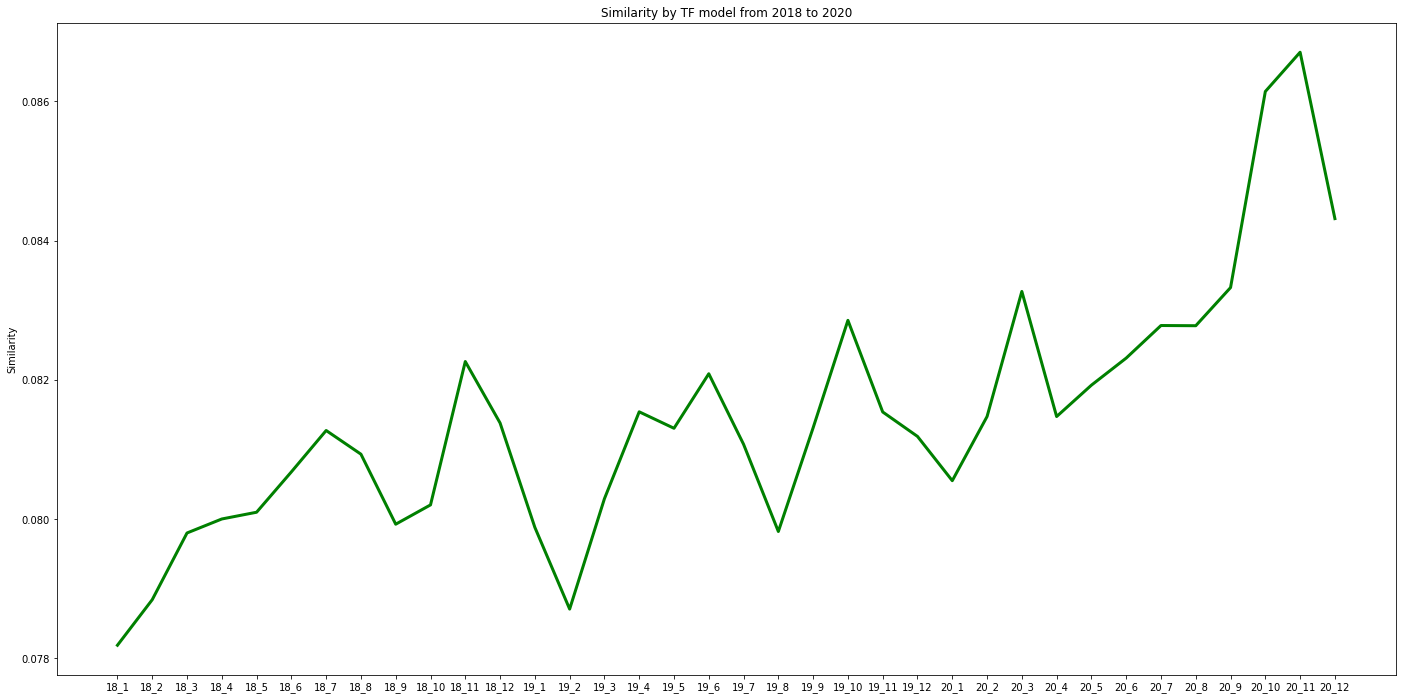

In [ ]:
# 制作x刻度  
datapath= path+'My_result/TF-IDF/Final_SimList_TF_Summary.npy'
years = ['18','19','20']
months=['1','2','3','4','5','6','7','8','9','10','11','12']
x_line =[]

for year in years:
  for month in months:
    x_word = year+'_'+month
    x_line.append(x_word)

# IF + title
sim_year_if_1 = np.load(datapath)
sim_year_if_1 = sim_year_if_1.tolist()
sim_year_if_1_in = sim_year_if_1[::-1]


# 画图

fig, ax = plt.subplots(figsize=(24, 12))
x = x_line
y = sim_year_if_1_in[36:72]
ax.plot(x,y, linewidth=3,color='green')
ax.set_title('Similarity by TF model from 2018 to 2020')
ax.set_ylabel('Similarity')

In [ ]:
'''
a = np.load(path+'My_Process/similarity_data_per_year.npy')
a = a.tolist()

a
'''

"\na = np.load(path+'My_Process/similarity_data_per_year.npy')\na = a.tolist()\n\na\n"

In [ ]:

b=[]
b = np.array(b)
np.save(path+'My_result/similarity_tfidf_2.npy',b)


In [ ]:
practise = data[:10]

In [ ]:
#transfer_tfidf = TfidfVectorizer(stop_words=stopwords)
transfer_tf = CountVectorizer(stop_words=stopwords)
tfidf_result_tf = transfer_tf.fit_transform(practise)
array_tf_result = tfidf_result_tf.toarray()
array_tf_result = array_tf_result.astype(float)

In [ ]:
norm = []
for index in range(len(array_tf_result)):
  length = np.linalg.norm(array_tf_result[index])
  norm.append(array_tf_result[index]/length)

In [ ]:
print('norm is of :',len(norm))
for element in norm:
  print(np.linalg.norm(element))

norm is of : 10
0.9999999999999999
1.0
0.9999999999999999
1.0
1.0
1.0
1.0
0.9999999999999999
1.0
0.9999999999999999


In [ ]:
norm=np.array(norm)
norm[0]

array([0.        , 0.        , 0.09407209, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.09407209, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.09407209, 0.        , 0.        , 0.        ,
       0.        , 0.09407209, 0.        , 0.        , 0.        ,
       0.        , 0.09407209, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.09407209, 0.        , 0.09407209, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.09407209, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.09407209,
       0.        , 0.        , 0.09407209, 0.        , 0.     

In [ ]:
a_1 = array_tf_result[:20000,:]
a_2 = array_tf_result[20000:,:]
a_2 = a_2.T


In [ ]:
np.dot(a_1,a_2)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
print('特征名字：\n',transfer_tf.get_feature_names())

特征名字：
 ['analysis', 'application', 'architechture', 'base', 'basis', 'big', 'block', 'building', 'business', 'challenge', 'cloud', 'concept', 'context', 'datum', 'distance', 'diversion', 'driver', 'efficient', 'function', 'generalize', 'hybrid', 'internet', 'model', 'network', 'neural', 'paradigm', 'process', 'radial', 'reliable', 'strategy', 'thing', 'training', 'web']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# 训练
practise = data[114337:160190]
transfer_tfidf = TfidfVectorizer(stop_words=stopwords)
tfidf_result_tfidf = transfer_tfidf.fit_transform(practise)
array_tfidf_result = tfidf_result_tfidf.toarray()


In [ ]:
# 计算
b_1 = array_tfidf_result[1]
b_2 = array_tfidf_result[3]
b_2_1 = b_2.T
print(np.linalg.norm(b_1))
print(np.linalg.norm(b_2))

0.9999999999999999
1.0
